### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import squarify
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
data = pd.read_csv("dataset/train.csv")

In [3]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
data.shape

(550068, 12)

### Calculate percentage of Null values for each attribute

In [5]:
data.isnull().sum()/data.shape[0]*100

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

<AxesSubplot:title={'center':'Purchase Distribution'}, xlabel='Purchase', ylabel='Density'>

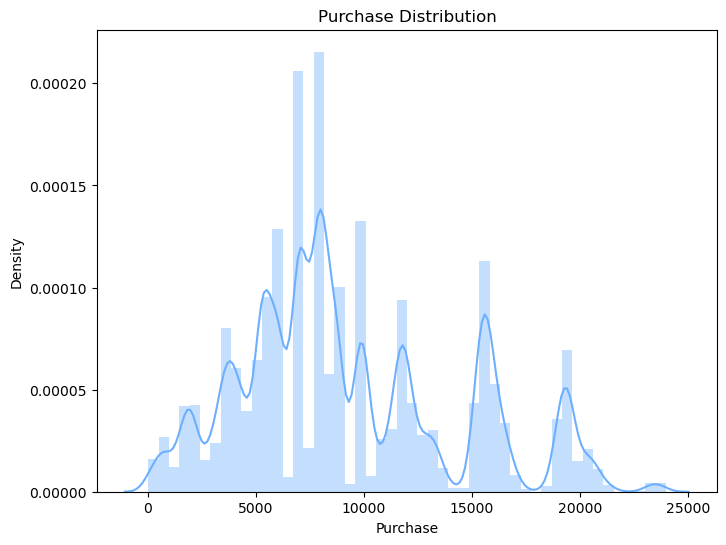

In [6]:
plt.figure(figsize = (8,6))
plt.title("Purchase Distribution")
sns.distplot(data['Purchase'],color = '#6DAFFE')

In [7]:
def create_category_mean_plot(x, y, x_label):
    plt.bar(x, y)
    plt.rcParams["figure.autolayout"] = True
    plt.title("Bar Chart with Mean Value")
    plt.xlabel(x_label)
    plt.ylabel("Mean Value")

    plt.show()

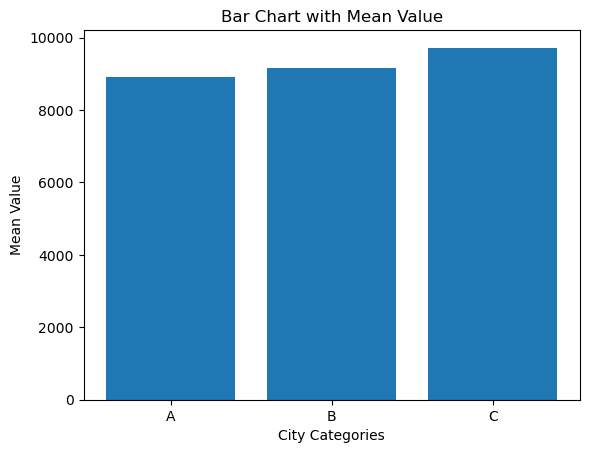

In [8]:
create_category_mean_plot(sorted(data["City_Category"].unique().tolist()), 
                          data.groupby("City_Category")["Purchase"].mean().values.tolist(), 
                          "City Categories")

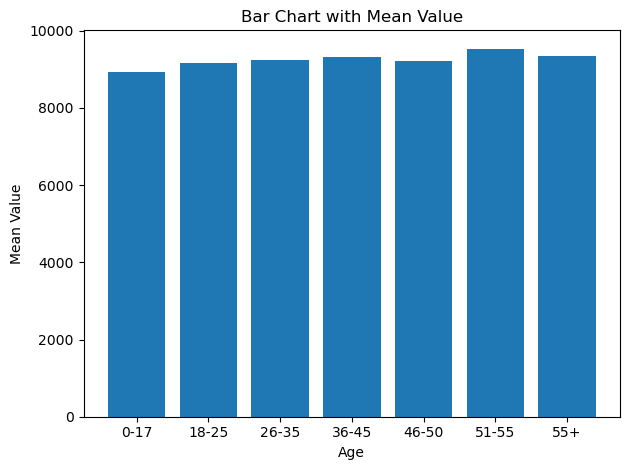

In [9]:
create_category_mean_plot(sorted(data["Age"].unique().tolist()), 
                          data.groupby("Age")["Purchase"].mean().values.tolist(),
                          "Age")

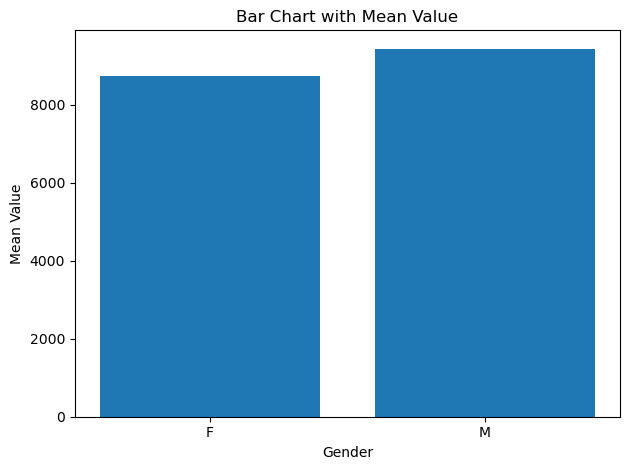

In [10]:
create_category_mean_plot(data["Gender"].unique().tolist(), 
                          data.groupby("Gender")["Purchase"].mean().values.tolist(),
                          "Gender")

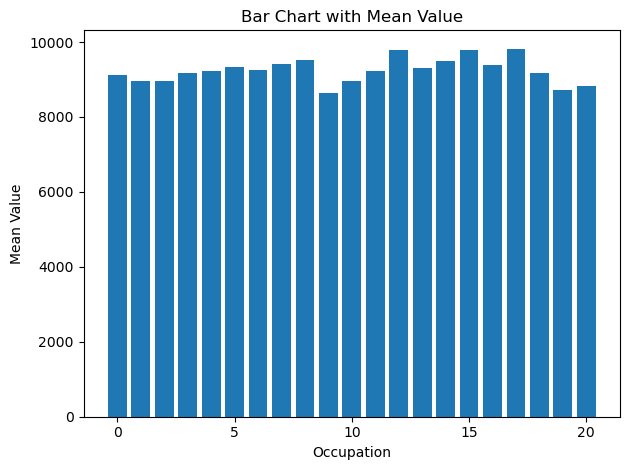

In [11]:
create_category_mean_plot(sorted(data["Occupation"].unique().tolist()), 
                          data.groupby("Occupation")["Purchase"].mean(),
                          "Occupation")


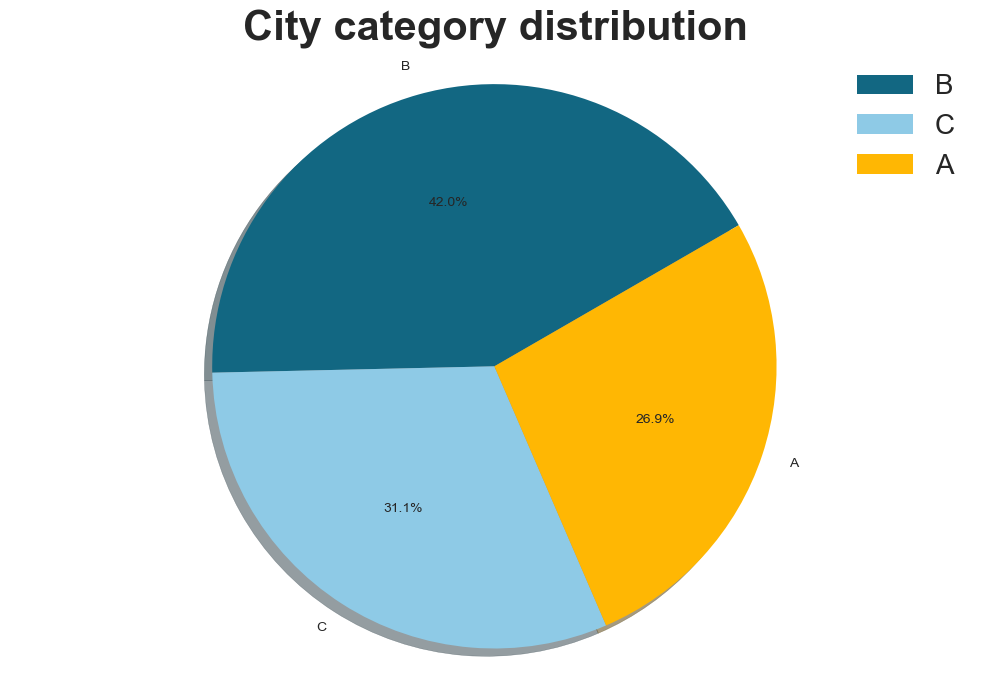

In [12]:
city = data['City_Category'].value_counts()

plt.style.use('seaborn')
plt.figure(figsize = (10, 7))
plt.pie(city.values, labels = city.index, startangle = 30, 
        shadow = True, autopct = '%1.1f%%', colors = ["#126782", "#8ecae6", "#ffb703"])
plt.title('City category distribution', fontdict = {'fontsize' : 30, 'fontweight' : 'bold'})
plt.legend()
plt.legend(prop = {'size' : 20})
plt.axis('equal')
plt.show()

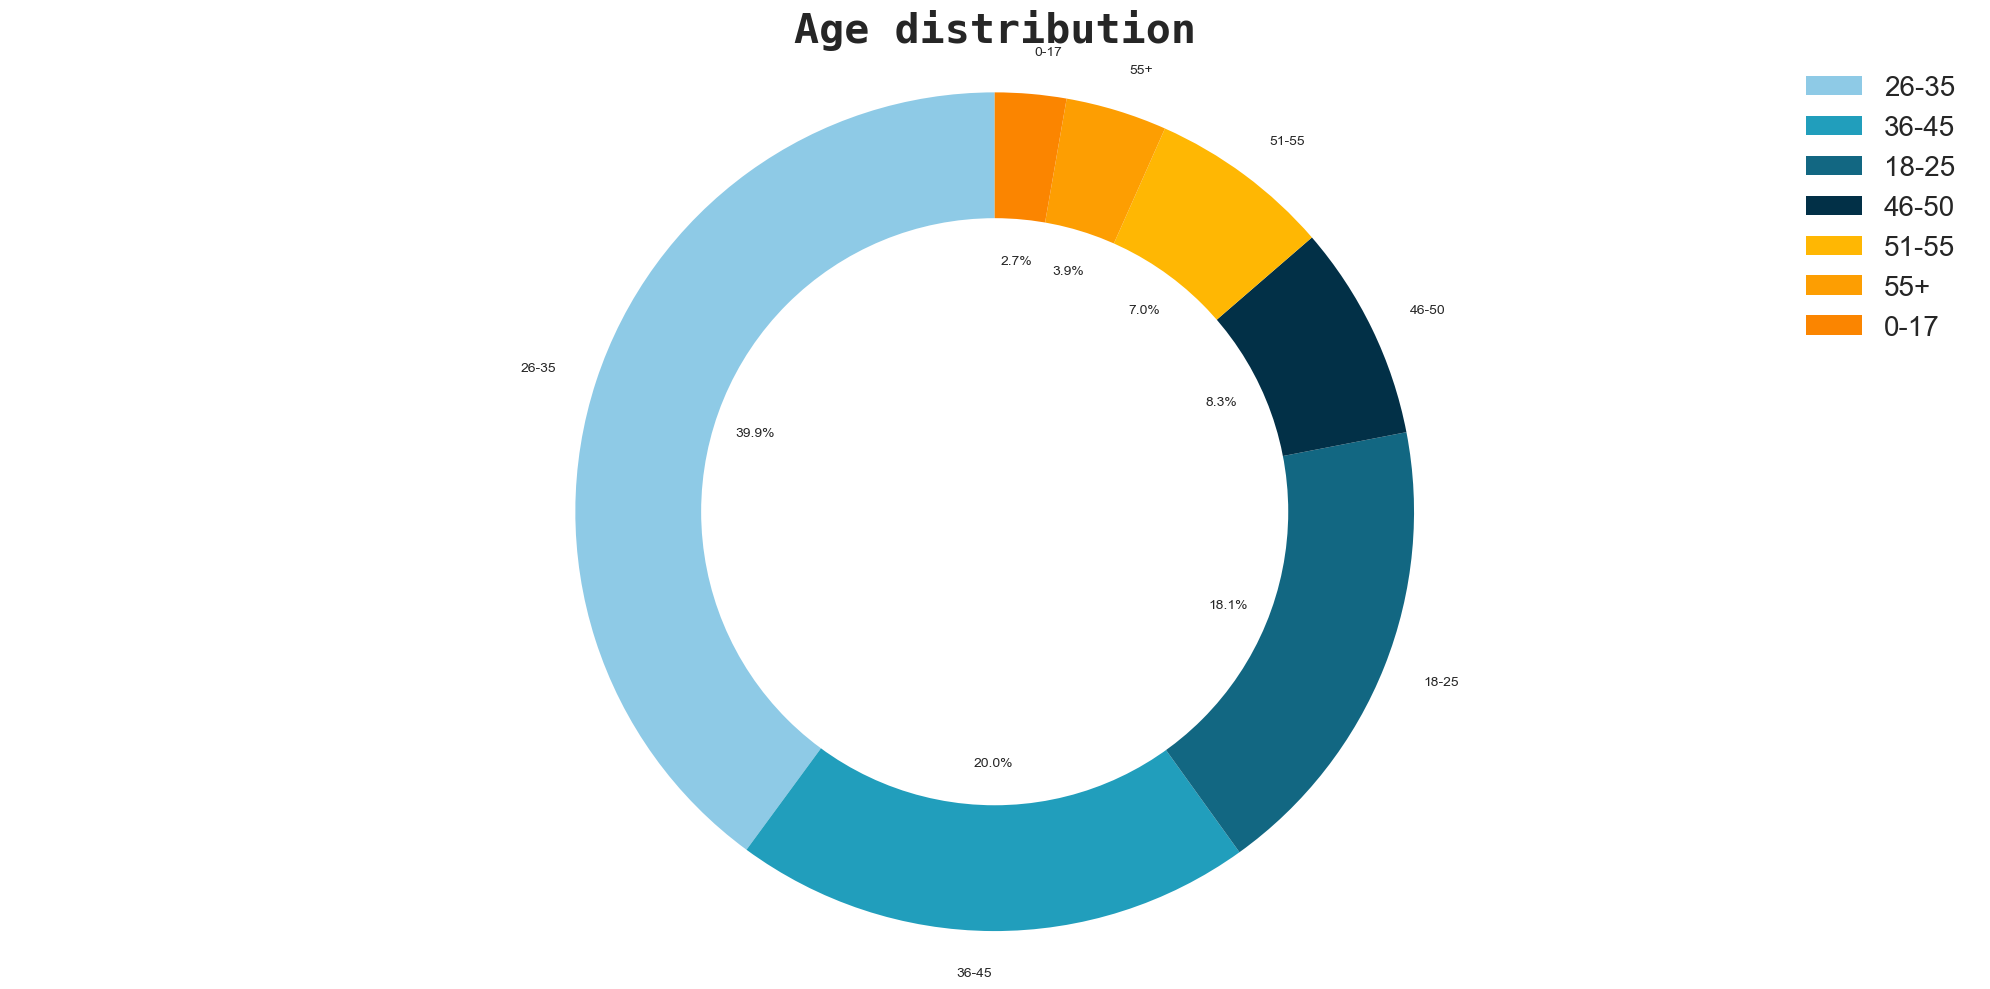

In [13]:
age = data['Age'].value_counts()

plt.style.use('bmh')
plt.figure(figsize = (20, 10))
plt.pie(age.values, labels = age.index, startangle = 90, 
        autopct = '%1.1f%%', colors = ["#8ecae6", "#219ebc", "#126782", "#023047", "#ffb703", "#fd9e02", "#fb8500"])
centre_circle = plt.Circle((0, 0), 0.7, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Age distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.axis('equal')
plt.legend(prop = {'size' : 20})
plt.show()

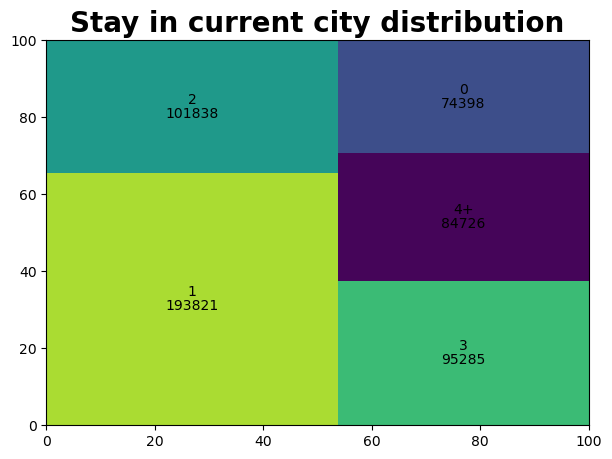

In [14]:
stay = data['Stay_In_Current_City_Years'].value_counts()

plt.style.use('default')
plt.figure(figsize = (7, 5))
squarify.plot(sizes = stay.values, label = stay.index, value = stay.values)
plt.title('Stay in current city distribution', fontdict = {'fontsize' : 20, 'fontweight' : 'bold'})
plt.show()

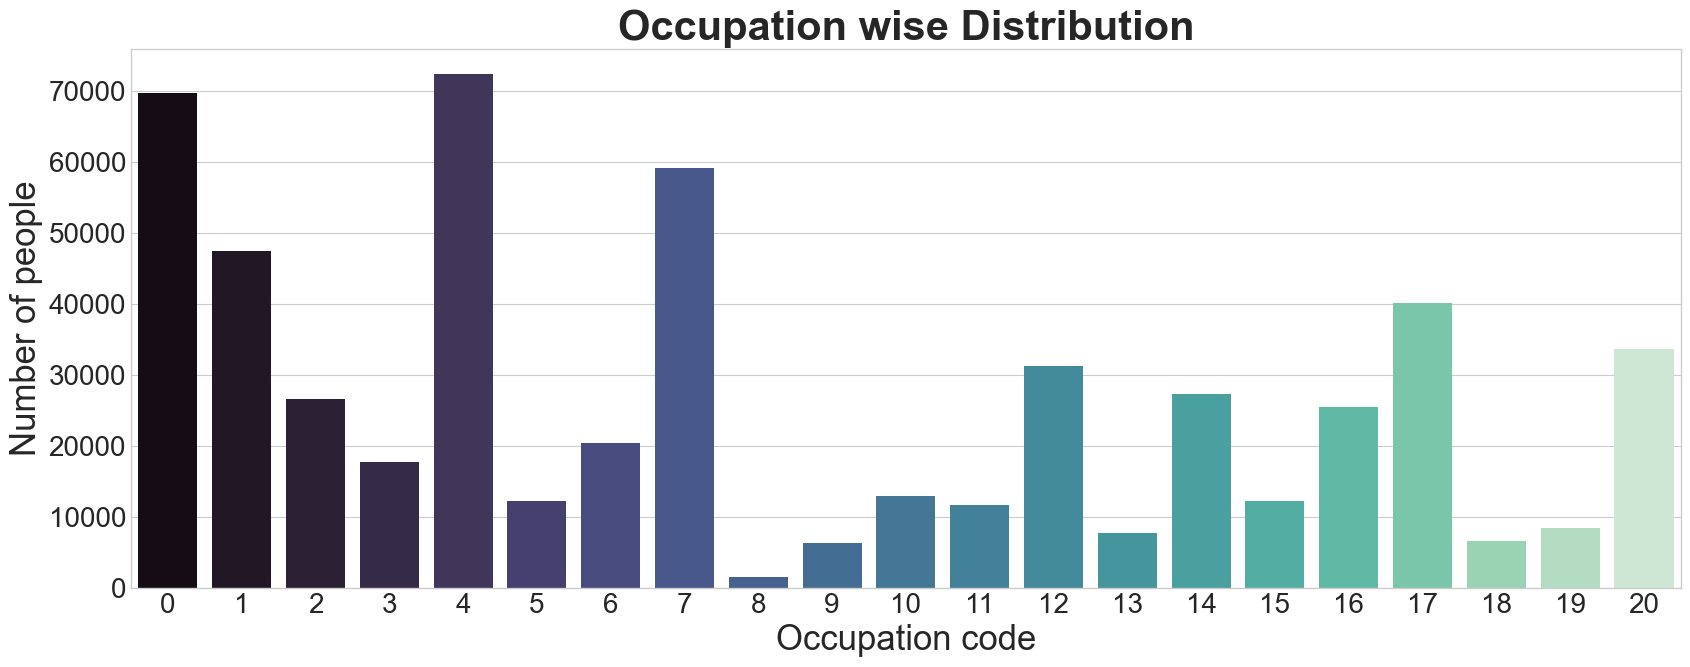

In [15]:
occupation = data['Occupation'].value_counts()
plt.figure(figsize = (20, 7))
plt.style.use('seaborn-whitegrid')
sns.barplot(occupation.index, occupation.values, palette = 'mako')
plt.title('Occupation wise Distribution', fontdict = {'fontsize' : 30, 'fontweight' : 'bold'})
plt.xlabel('Occupation code', fontdict = {'fontsize' : 25})
plt.ylabel('Number of people', fontdict = {'fontsize' : 25})
plt.tick_params(labelsize = 20)
plt.show()

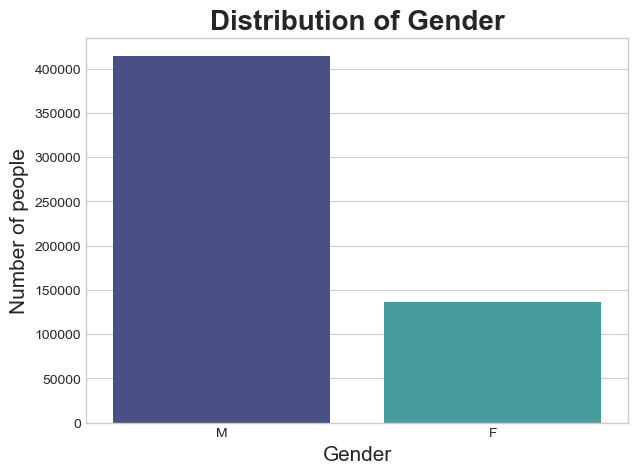

In [16]:
gen = data['Gender'].value_counts()
plt.figure(figsize = (7, 5))
plt.style.use('seaborn-whitegrid')
sns.barplot(gen.index, gen.values, palette = 'mako')
plt.title('Distribution of Gender', fontdict = {'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Gender', fontdict = {'fontsize' : 15})
plt.ylabel('Number of people', fontdict = {'fontsize' : 15})
plt.tick_params(labelsize = 10)
plt.show()

In [17]:
data["Stay_In_Current_City_Years"].replace({'0':0,
                                         '1':1,
                                         '2':4,
                                         '3':3,
                                         '4+':2},inplace = True)

data["Gender"].replace({'M':1,'F':0},inplace = True)

data["Age"].replace({'0-17' :17,
                  '18-25':20,
                  '26-35':30,
                  '36-45':40,
                  '46-50':47,
                  '51-55':52,
                  '55+' : 56},
                 inplace = True)


In [18]:
data_city_categories = pd.get_dummies(data['City_Category'])
data_city_categories = data_city_categories.add_prefix("City_Category_")

In [19]:
data = pd.concat([data, data_city_categories], axis=1)
try:
    data = data.drop(['City_Category'], axis = 1)
except:
    pass
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_A,City_Category_B,City_Category_C
0,1000001,P00069042,0,17,10,4,0,3,NaN,NaN,8370,1,0,0
1,1000001,P00248942,0,17,10,4,0,1,6.0,14.0,15200,1,0,0
2,1000001,P00087842,0,17,10,4,0,12,NaN,NaN,1422,1,0,0
3,1000001,P00085442,0,17,10,4,0,12,14.0,NaN,1057,1,0,0
4,1000002,P00285442,1,56,16,2,0,8,NaN,NaN,7969,0,0,1


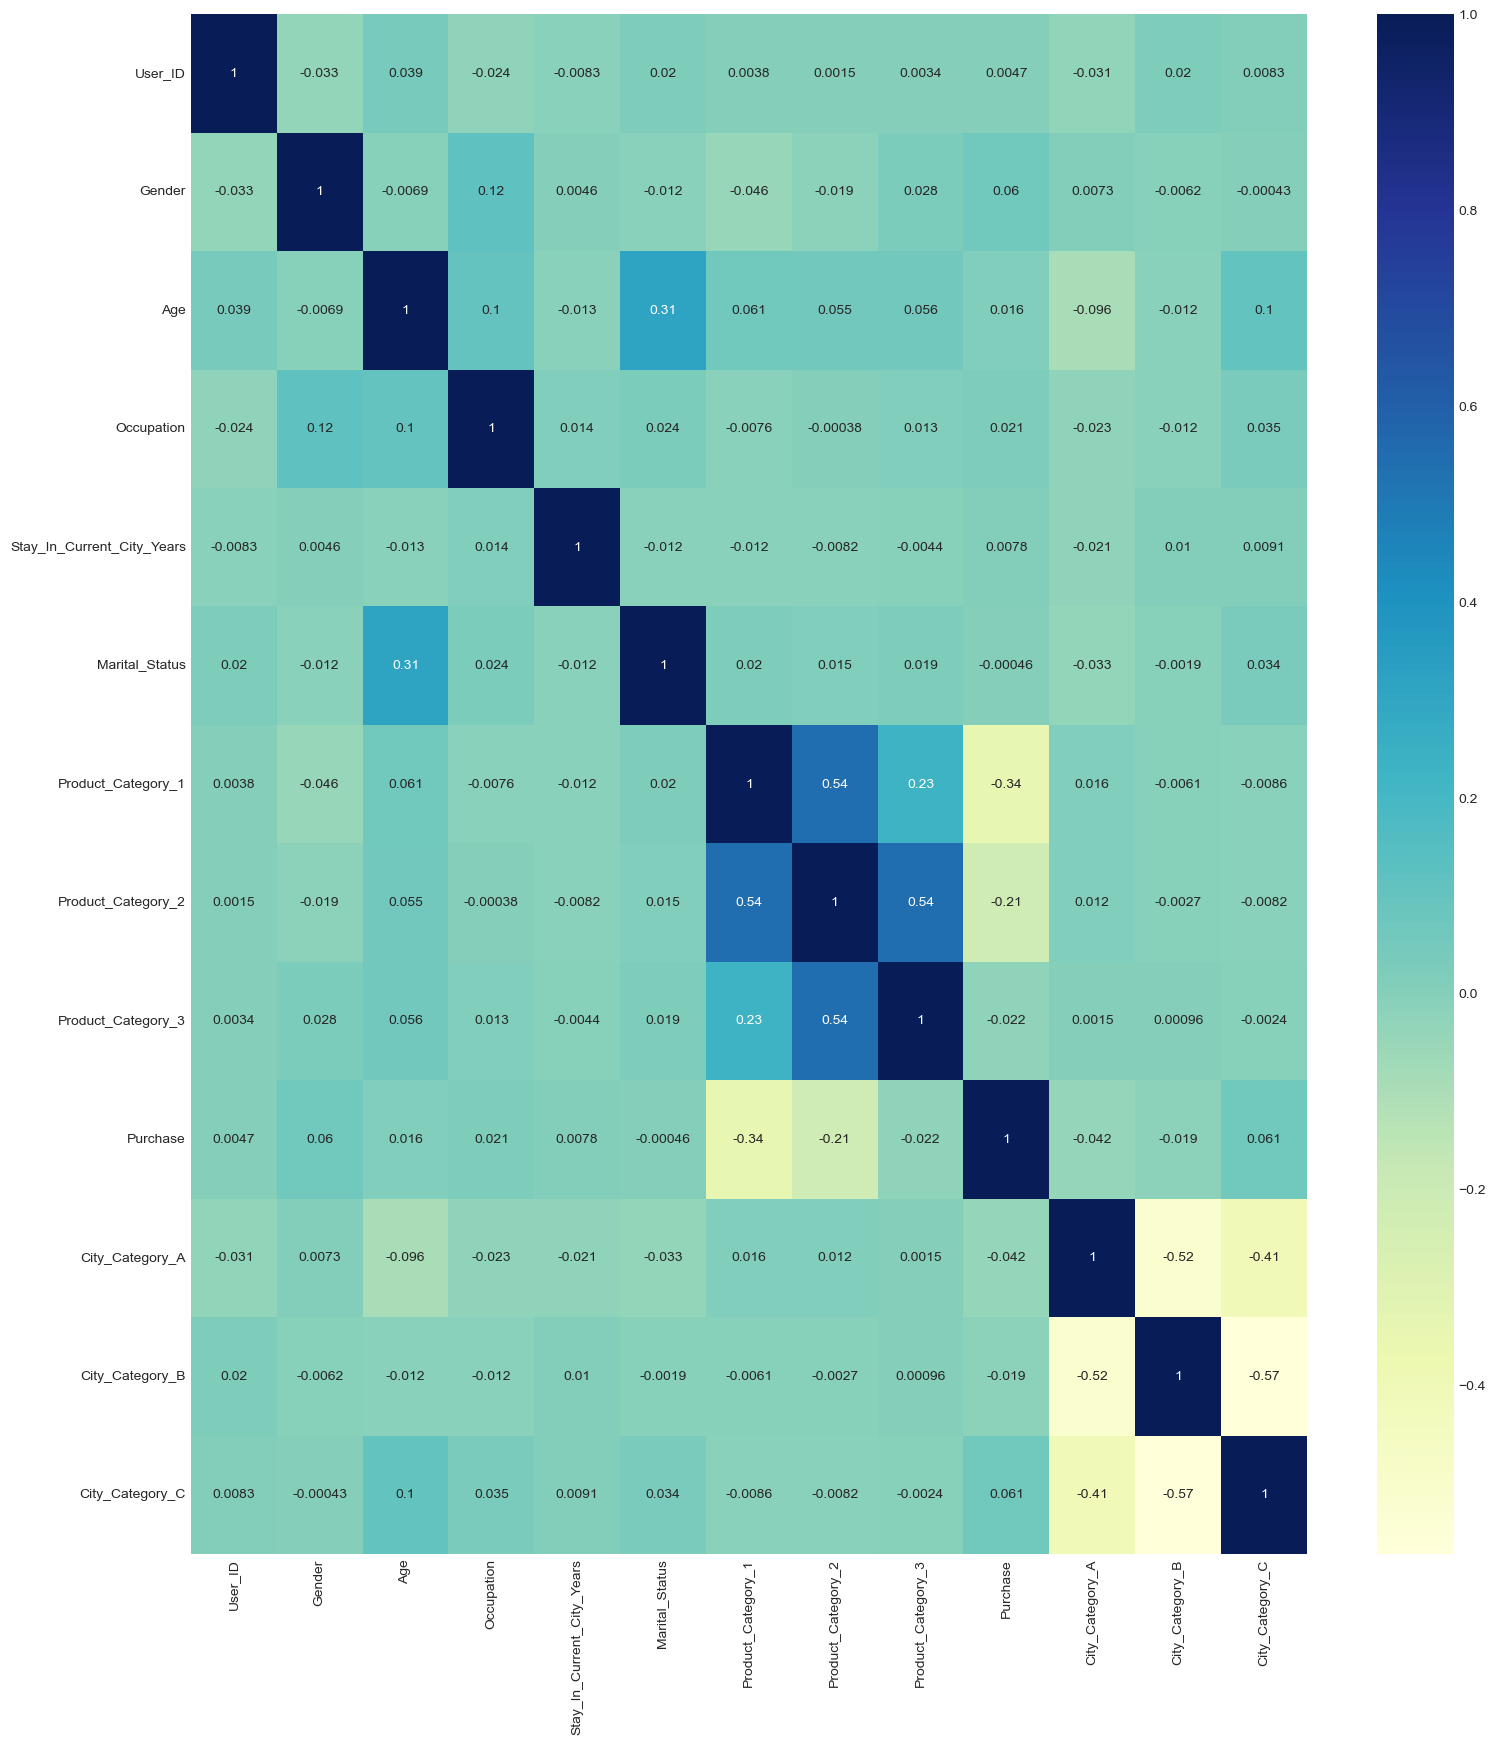

In [20]:
data.corr(method='pearson')
plt.figure(figsize = (18,20))
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [21]:
data.shape

(550068, 14)

In [22]:
data['Product_Category_2'] =data['Product_Category_2'].fillna(0)
data['Product_Category_3'] =data['Product_Category_3'].fillna(0)
y = data["Purchase"]
X = data.drop(['Purchase', "Product_ID", "User_ID"], axis = 1)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data.head(10)
data.isnull().sum()/data.shape[0]*100
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)

0          8370
1         15200
2          1422
3          1057
4          7969
          ...  
550063      368
550064      371
550065      137
550066      365
550067      490
Name: Purchase, Length: 550068, dtype: int64


array([[ 0.57640563,  1.71217615,  1.67237598, ..., -0.60411497,
        -0.85449443,  1.48980322],
       [-1.73488936,  0.58216896,  0.4471647 , ..., -0.60411497,
         1.17028265, -0.67122959],
       [-1.73488936,  0.58216896, -1.23750081, ...,  1.65531405,
        -0.85449443, -0.67122959],
       ...,
       [ 0.57640563,  0.58216896,  1.82552739, ...,  1.65531405,
        -0.85449443, -0.67122959],
       [ 0.57640563,  0.58216896, -0.16544094, ...,  1.65531405,
        -0.85449443, -0.67122959],
       [-1.73488936, -1.58367815,  0.29401329, ...,  1.65531405,
        -0.85449443, -0.67122959]])

In [23]:
#data.info()

xgb = XGBRegressor(colsample_bytree = 0.8, gamma = 0.1, learning_rate = 0.1, max_depth = 11, min_child_weight = 10, verbosity = 0, random_state = 42)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [24]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [25]:
xgb_pred = xgb.predict(X_test)

In [26]:
XGB_MAE = mean_absolute_error(y_test,xgb_pred)
print(XGB_MAE)

2125.1095240105933


In [27]:
rms = math.sqrt(mean_squared_error(y_test,xgb_pred))
print(rms)

2858.234190274183


In [28]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_pred)

0.6748609337209119